# NeRF Activation Sparsity
Run the `accelerating_nerfs/nerf_activation_sparsity.py` script to compute the sparsities. You need to use the NeRF environment for that.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from typing import Optional

# Custom code
from analysis import load_nerf_sparsities, compute_layer_sparsities, compute_overall_sparsity
from notebook_utils import load_mpl_style

load_mpl_style()
fig_dir = "figures/activation"
os.makedirs(fig_dir, exist_ok=True)

In [2]:
!ls ../accelerating_nerfs/sparsity

chair_sparsity.json  hotdog_sparsity.json     mic_sparsity.json
drums_sparsity.json  lego_sparsity.json       ship_sparsity.json
ficus_sparsity.json  materials_sparsity.json


In [3]:
# Load and process scene sparsity results
sparsity_results = load_nerf_sparsities("../accelerating_nerfs/sparsity")
scene_to_sparsity = defaultdict(dict)

for scene, results in sparsity_results.items():
    for layer, fc_label in zip(results["layers"], results["fc_labels"]):
        layer_id = int(fc_label.split('_')[1])
        # Calculate mean and std of input and output sparsities
        input_sparsities = np.array(results["input"]["sparsities"][layer])
        output_sparsities = np.array(results["output"]["sparsities"][layer])
        assert len(input_sparsities) == len(output_sparsities)
        scene_to_sparsity[scene][layer_id] = {
            "input_sparsity": np.mean(input_sparsities),
            "input_sparsity_std": np.std(input_sparsities),
            "input_sparsities": input_sparsities,
            "output_sparsity": np.mean(output_sparsities),
            "output_sparsity_std": np.std(output_sparsities),
            "output_sparsities": output_sparsities,
            "num": len(input_sparsities),
            "layer": layer,
        }
        
# Convert into dataframes
dfs = [pd.DataFrame.from_dict(results, orient="index") for results in scene_to_sparsity.values()]

Loaded sparsity results for dict_keys(['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship'])


### Average sparsity per layer over all scenes

In [4]:
layer_to_avg_sparsity = compute_layer_sparsities(sparsity_results)

for sparsity_key in ["input_sparsity", "output_sparsity"]:
    print(f"===== Average {sparsity_key} over all scenes =====")
    for layer, sparsity in layer_to_avg_sparsity.items():
        print(f"Layer {layer} = {sparsity[sparsity_key]}")

===== Average input_sparsity over all scenes =====
Layer 1 = {'mean': 4.3946616992536214e-08, 'std': 4.918707813129488e-07, 'num': 27708}
Layer 2 = {'mean': 0.5542258571408987, 'std': 0.03391004992789977, 'num': 27708}
Layer 3 = {'mean': 0.6947238747829664, 'std': 0.03819135012459017, 'num': 27708}
Layer 4 = {'mean': 0.7004855604878076, 'std': 0.0401906050789546, 'num': 27708}
Layer 5 = {'mean': 0.6893779538928241, 'std': 0.0344373699693345, 'num': 27708}
Layer 6 = {'mean': 0.541798863641495, 'std': 0.03929933042345445, 'num': 27708}
Layer 7 = {'mean': 0.6500948969546201, 'std': 0.04782291053415555, 'num': 27708}
Layer 8 = {'mean': 0.6938947154922879, 'std': 0.060957404355100955, 'num': 27708}
Layer 9 = {'mean': 0.6987572914015378, 'std': 0.037907699771396394, 'num': 27708}
Layer 10 = {'mean': 0.6870557599287539, 'std': 0.03621108286053783, 'num': 13854}
Layer 11 = {'mean': 2.4972324112363578e-09, 'std': 6.142307098905525e-08, 'num': 13854}
Layer 12 = {'mean': 0.7121127001079874, 'std'

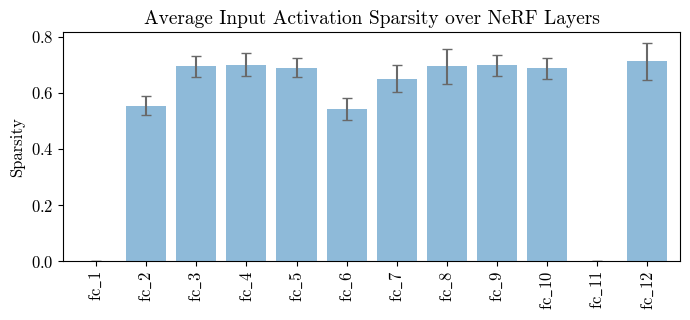

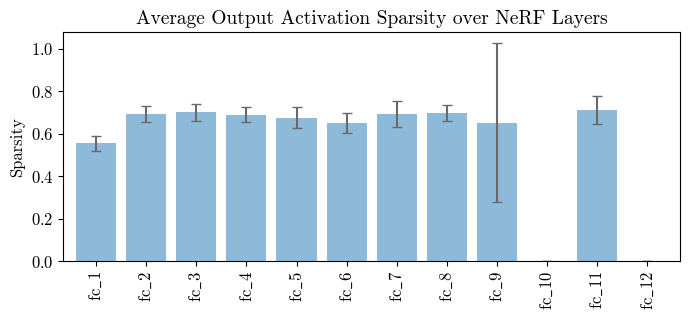

In [5]:
for sparsity_type in ["input", "output"]:
    df = pd.DataFrame.from_dict(
        {k: v[f"{sparsity_type}_sparsity"] for k, v in layer_to_avg_sparsity.items()},
        orient="index"
    )
    err = df["std"]
    ax = df.plot.bar(
        y="mean", yerr=err, width=0.8, figsize=(7, 3.3), 
        align='center', alpha=0.5, ecolor='dimgray', capsize=3.5
    )
    ax.set_xticklabels(["$\mathrm{fc}\_" + str(v.item()) + "$" for v in df.index.values])
    ax.get_legend().remove()
    ax.set_title(f"Average {sparsity_type.capitalize()} Activation Sparsity over NeRF Layers")
    # ax.set_xlabel("Layer")
    ax.set_ylabel("Sparsity")
    ax.figure.tight_layout()
    ax.figure.savefig(f"{fig_dir}/layer_{sparsity_type}_sparsity.pdf")

### Average sparsity over all layers over all scenes

In [6]:
overall_sparsity = compute_overall_sparsity(sparsity_results)
print("=== Average sparsity over all layers ===")
for sparsity_type, results in overall_sparsity.items():
    print(f"{sparsity_type}: {results}")

Deleting input sparsity for layer 1 with mean 4.3946616992536214e-08
Deleting output sparsity for layer 10 with mean 2.163834528961967e-09
Deleting input sparsity for layer 11 with mean 2.4972324112363578e-09
Deleting output sparsity for layer 12 with mean 0.0
=== Average sparsity over all layers ===
input_sparsity: {'mean': 0.6581048048680896, 'std': 0.07487376598900568, 'num': 249372}
output_sparsity: {'mean': 0.670000828807318, 'std': 0.13602521934421571, 'num': 263226}


## Plot input activation sparsity for each FC layer
Notes:

- `fc_1` is the layer that gets the position encoded ray samples
- `fc_11` is the first hidden layer of the RGB MLP, that gets input from the bottleneck layer which doesn't have an activation function.

===== chair =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6415253583261931
===== drums =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6547293642000122
===== ficus =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6599154698974414
===== hotdog =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6512334966586046
===== lego =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6408965191841306
===== materials =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6642717437667441
===== mic =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mean sparsity over layers with sparsity: 0.6644339064907115
===== ship =====
Layers with sparsity: [ 2  3  4  5  6  7  8  9 10 12]
mea

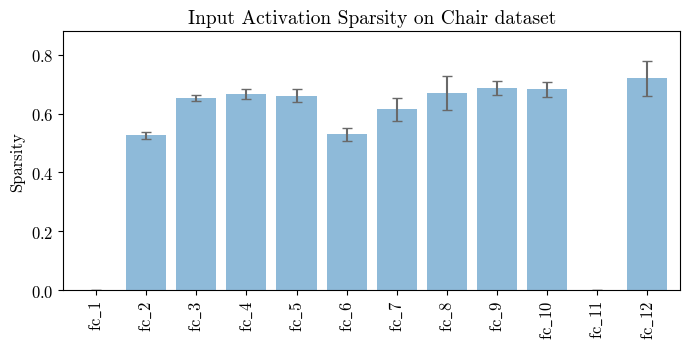

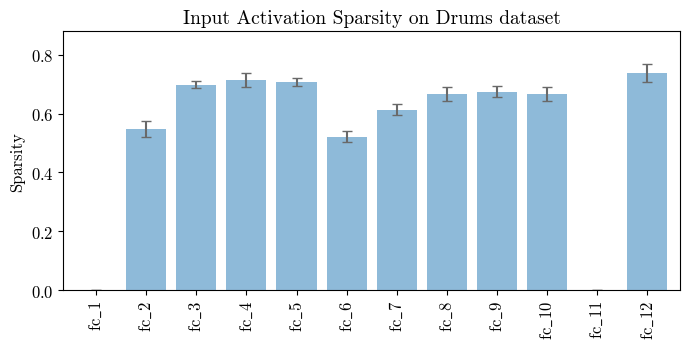

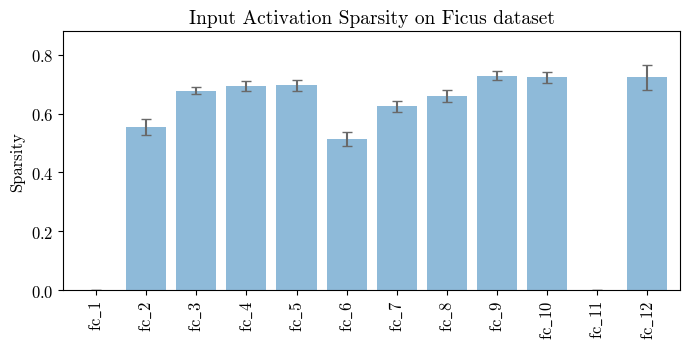

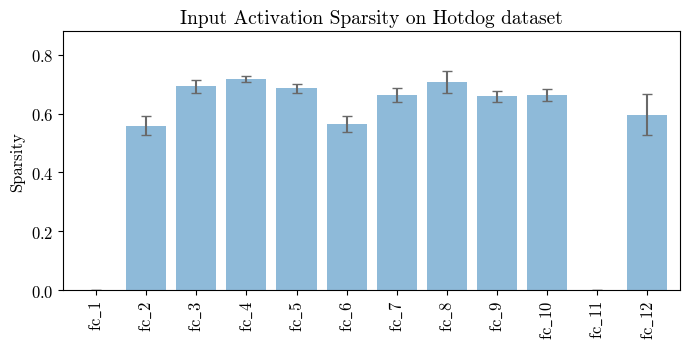

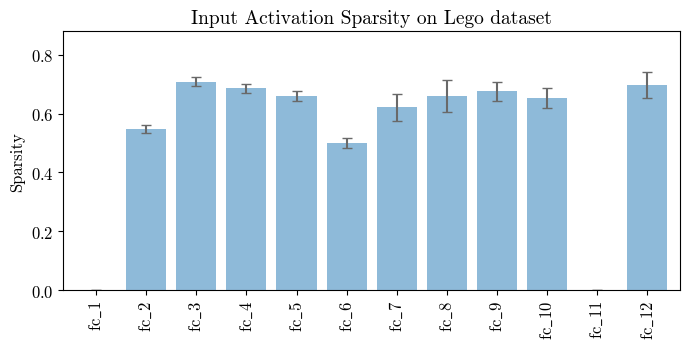

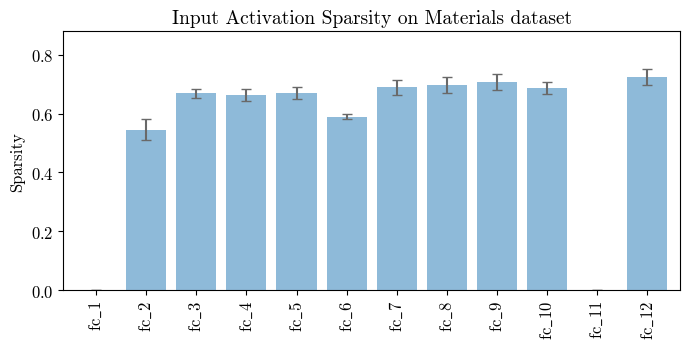

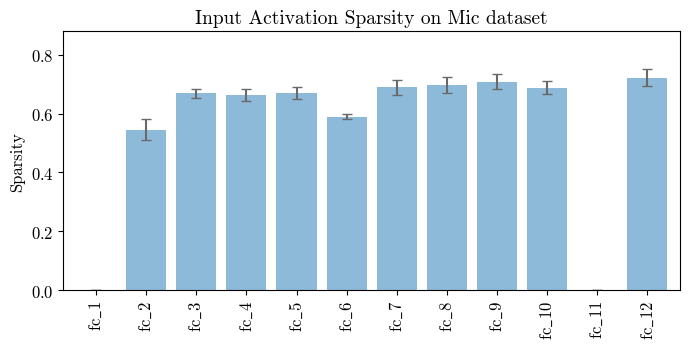

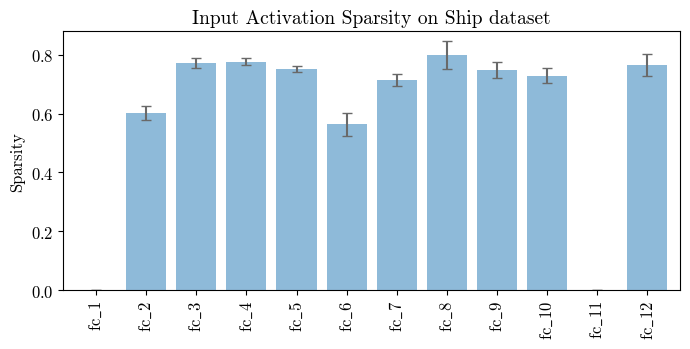

In [7]:
def plot(sparsity_type: str, y_lim: Optional[float] = None):
    assert sparsity_type in {"input", "output"}
    
    mean_sparsities = []
    sparsity_key = f"{sparsity_type}_sparsity"
    sparsity_std_key = f"{sparsity_type}_sparsity_std"
    
    for label, df in zip(scene_to_sparsity.keys(), dfs):
        # err = 1.96 * df[sparsity_std_key] / np.sqrt(df['num'])
        err = df[sparsity_std_key]
        ax = df.plot.bar(
            y=sparsity_key, yerr=err, width=0.8, figsize=(7, 3.6), 
            align='center', alpha=0.5, ecolor='dimgray', capsize=3.5
        )
        ax.set_xticklabels(["$\mathrm{fc}\_" + str(v.item()) + "$" for v in df.index.values])
        ax.get_legend().remove()
        ax.set_title(f"{sparsity_type.capitalize()} Activation Sparsity on {label.capitalize()} dataset")
        # ax.set_xlabel("Layer")
        ax.set_ylabel("Sparsity")
        if y_lim is not None:
            ax.set_ylim(0.0, y_lim)
        ax.figure.tight_layout()
        ax.figure.savefig(f"{fig_dir}/{label}_{sparsity_type}_sparsity.pdf")

        df_has_sparsity = df[df[sparsity_key] > 0.01]
    
        print(f"===== {label} =====")
        print(f"Layers with sparsity: {df_has_sparsity.index.values}")
        mean_sparsity = df_has_sparsity[sparsity_key].mean()
        print(f"mean sparsity over layers with sparsity: {mean_sparsity}")
        mean_sparsities.append(mean_sparsity)
    
    print('==========')
    print(f"Overall {sparsity_type} activation mean sparsity: {np.mean(mean_sparsities)}")


plot("input", y_lim=0.88)

## Plot output activation sparsity for each FC layer

===== chair =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6529815066981803
===== drums =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6708778100344661
===== ficus =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6750487494957764
===== hotdog =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6624024415305413
===== lego =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6543895694135887
===== materials =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6705915114853352
===== mic =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mean sparsity over layers with sparsity: 0.6708293120058345
===== ship =====
Layers with sparsity: [ 1  2  3  4  5  6  7  8  9 11]
mea

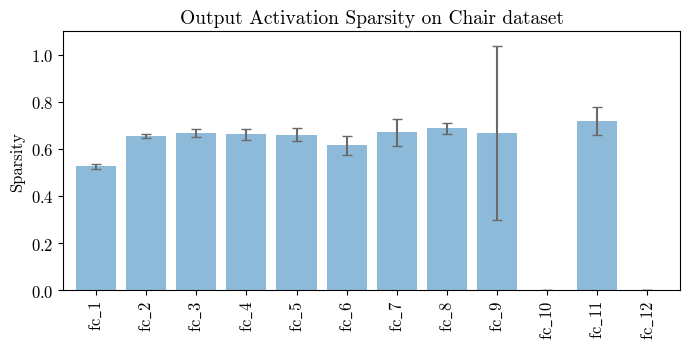

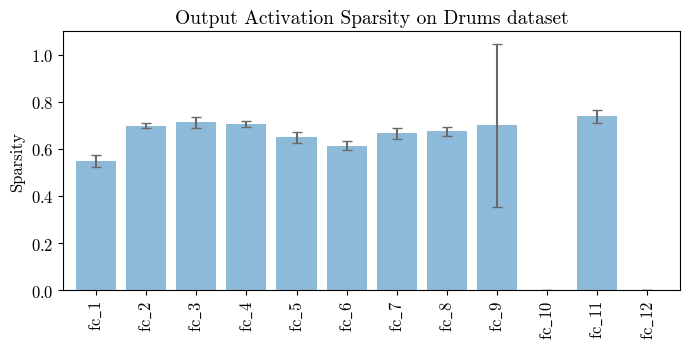

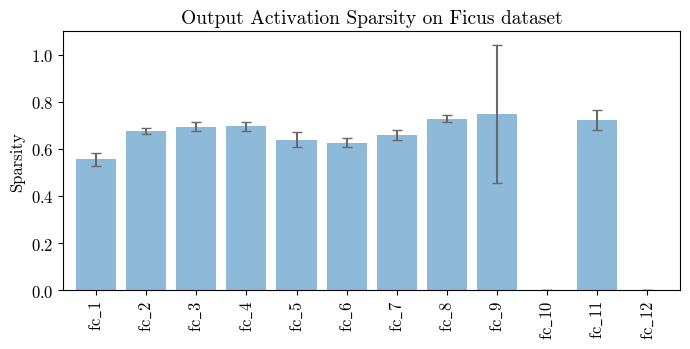

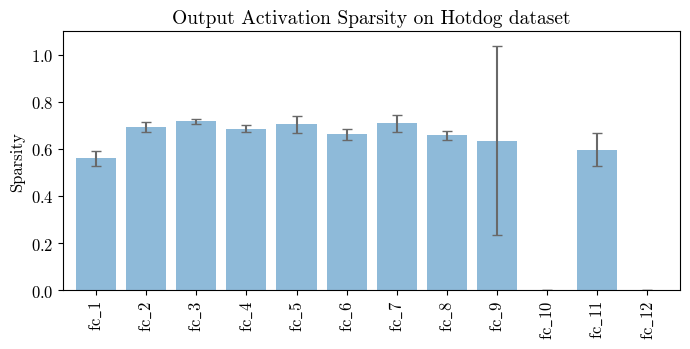

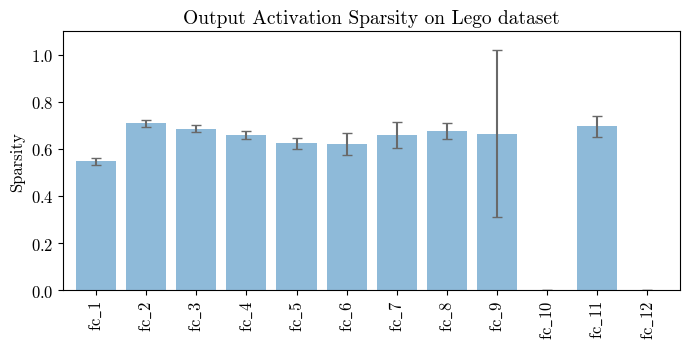

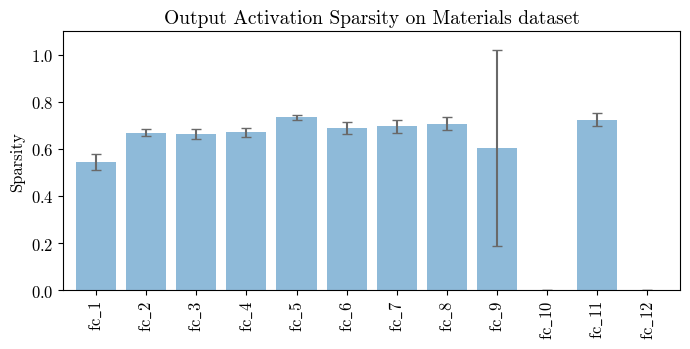

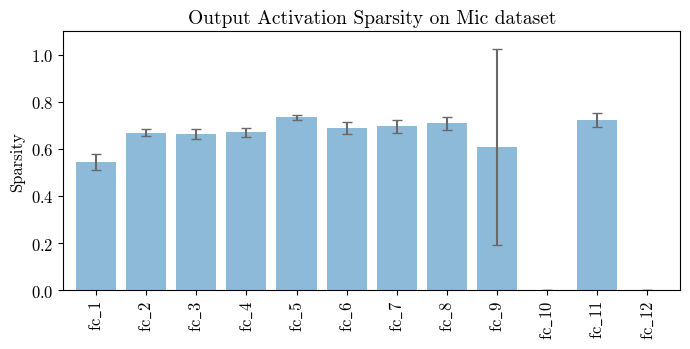

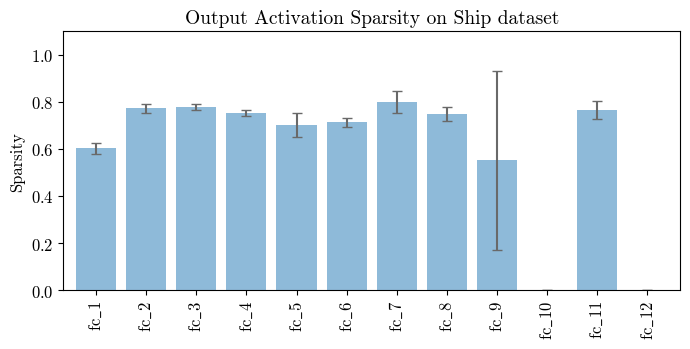

In [8]:
plot("output", y_lim=1.1)

## View NeRF architecture

In [9]:
from IPython.display import IFrame
IFrame("./figures/netdiag-modified.pdf", width=600, height=325)